# Reinforcement Learning from Scratch Part 1: Applying Q-learning given Environment Function

## Solving an Example Task of Throwing Paper into a Bin

This notebook attempts to solve a basic task of throwing paper into a bin using reinforcement learning. In this problem, we may throw from any position in the room but the probability of it is relative to the current distance from the bin and the direction in which the paper is thrown. Therefore the actions available are to throw the paper in any 360 degree direction or move to a new position to try and increase the probability that a throw made will go into the bin.



## Part 1: The Environment Function

The environment's probabilities are calcualted based on the direction in which the paper is thrown and the current distance from the bin. 

For example, in the image below we have three people labelled A, B and C. A and B both throw in the correct direction but person A is closer than B and so will have a higher probability of landing the shot. 

Person C is closer than person B but throws in the completely wrong direction and so will have a very low probability of hitting the bin. This may seem illogical that person C would throw in this direction but, as we will show more later, an algorithm has to try a range of directions first to figure out where the successes are and will have no visual guide as to where the bin is. 

![Enironment Demo](https://i.imgur.com/3woVbKI.png)



We don't need to worry too much about the acutal calculations yet as we can simply request the environment function from the Robot_env.py script.



In [2]:
import time
import pandas as pd
import numpy as np
import random
import seaborn as sns

sns.set_style("whitegrid")
sns.despine()


import matplotlib.pyplot as plt

from IPython.display import clear_output

from Robot_env import probability, action_request, environment

Initializing the Environment...
----------------------------
 
Pre-run Q Table Loaded
   Unnamed: 0 throw_dir move_dir  state_x  state_y  reward  prob
0           0         0     none      -10      -10       0   0.0
1           1         0     none      -10       -9       0   0.0
2           2         0     none      -10       -8       0   0.0
3           3         0     none      -10       -7       0   0.0
4           4         0     none      -10       -6       0   0.0


<Figure size 432x288 with 0 Axes>

In [3]:
action_request(-5, -5)[1]

['move', [array([0, 1, 2, 3, 4, 5, 6, 7], dtype=object)]]

In [4]:
state_x = -5
state_y = -5
action_type = 'throw'
action_dir = 45
env_output = environment(state_x, state_y, action_type, action_dir)
print("")
print("Current State: [", env_output[0], ",", env_output[1], "]")
print("Action: [", env_output[2],":", env_output[3],"]")
print("Reward = ", env_output[6])
print("Next State: [", env_output[4], ",", env_output[5], "]")
print("")
print("-----")
    



Current State: [ -5 , -5 ]
Action: [ throw : 45 ]
Reward =  1
Next State: [ none , none ]

-----


In [5]:
state_x = -5
state_y = -5
action_type = 'move'
action_dir = 0
env_output = environment(state_x, state_y, action_type, action_dir)
print("")
print("Current State: [", env_output[0], ",", env_output[1], "]")
print("Action: [", env_output[2],":", env_output[3],"]")
print("Reward = ", env_output[6])
print("Next State: [", env_output[4], ",", env_output[5], "]")
print("")
print("-----")



Current State: [ -5 , -5 ]
Action: [ move : 0 ]
Reward =  0
Next State: [ -5 , -4 ]

-----


## Format of the Q Table

In [6]:
state_x = -5
state_y = -5
action_type = 'move'
action_dir = 0

if action_type == 'throw':
    Q_table = pd.DataFrame({'throw_dir':action_dir,'move_dir':'none','state_x':state_x,'state_y':state_y,'Q':0}, index = [0])
else:
    Q_table = pd.DataFrame({'throw_dir':"none",'move_dir':action_dir,'state_x':state_x,'state_y':state_y, 'Q':0, 'V':0}, index = [0])

Q_table.head()

,throw_dir,move_dir,state_x,state_y,Q,V
0,none,0,-5,-5,0,0


## Action Selection Method: $\epsilon$-Greedy


We could use a random selection process but this is a highly inefficient method of choosing which action to take. When we implement our learning process we will begin to learn which actions lead towards the positive goal so if we keep randomly selecting we are wasting all that effort.

Therefore, we instead introduce a method that takes this into account, known as **epsilon-greedy**.

*The best lever is selected for a proportion $1-\epsilon$ of the trials, and a lever is selected at random (with uniform probability) for a proportion $\epsilon$ . A typical parameter value might be $epsilon =0.1$, but this can vary widely depending on circumstances and predilections.* ([wiki](https://en.wikipedia.org/wiki/Multi-armed_bandit))

In other words, we pick an action randomly with probability $\epsilon$ and will otherwise pick the best action. If we have mutliple "best actions" we then randomly select from this list.

So why do we not simply keep picking the best action each time? Well this can cause a problem if we have an action that works but is not neccessarily the best. This is often considered in other Machine Learning problems as the local minimum/maxmum. If we keep using an action that seems to work we may miss the opportunity to try a better action because we never tried it and this can cause instability in the results. 

The animation below demonstrates the outcome as we reduce epsilon. With high epsilon values, we are randomly selecting actions so will likely pick bad ones. As we reduce epsilon we select actions more and more greedily improving the results whilst still ensuring we can explore new actions to minimise the risk we are in a local max ratherh than global max.

**We therefore select a small epislon value $\epsilon = 0.1$**

![epsilon varied](https://i.imgur.com/Rx7HVAE.gif)

There are other methods that can be considered, such as the [Softmax Function](https://en.wikipedia.org/wiki/Softmax_function).

#### Action Cap
We also introduce an **action cap** which stops the episode occuring endlessly. If we reach this cap then we can consider the episode goal as negative but set it very large so is unlikely to reach it.

#### Action Selection between throw and move
Because we have many more throwing actions than moving action (360 vs 8), as before, we introduce the notion that have a 50/50 chance of being a throw or move action first and then subsequently select from these sub-choices. 

#### Code Format
Just to make things easier to track, we introduce a method that creates a data table with the output actions and will continue to use this for all methods. [Information on this can be found in this post](https://towardsdatascience.com/3-tips-to-improving-your-data-science-workflow-71a6fb8e6f19).e could continue this selection process but this is a highly inefficient method of choosing which action to take. When we implement our learning process we will begin to learn which actions lead towards the positive goal so if we keep randomly selecting we are wasting all that effort.


In [7]:
def eps_greedy_Q(Q_table, epsilon, state_x, state_y):
    rng_epsilon = np.random.rand()
    try:
        # If our rng is less than or equal to the epsilon parameter, we randomly select
        if rng_epsilon<=epsilon:
            # Introduce 50/50 chance for move or throw action
            rng = np.random.rand()
            if rng<=0.5:
                action_type = "throw"
            else:
                action_type = "move"
            # THROW ACTION
            if action_type == "throw":
                # Request possible throw directions from environment function
                throw_action_list = action_request(state_x, state_y)[0][1][0]
                action_dir = (random.choice(throw_action_list))
                # Output environment results
            # ELSE MOVE ACTION
            else:
                # Request possible directions from environment function
                move_action_list = action_request(state_x, state_y)[1][1][0]
                action_dir = (random.choice(move_action_list))
                
        #  If our rng is more than the epsilon parameter, we select the best action ("greedily")
        else:        
            sorted_actions = Q_table[(Q_table['state_x']==state_x) & (Q_table['state_y']==state_y)].sort_values('Q', ascending = False)
            best_action = sorted_actions[sorted_actions['Q'] == sorted_actions['Q'].iloc[0]]
            
            # If we only have one best action, simply pick this
            if len(best_action)==1:
                action = best_action
                if action['throw_dir'].iloc[0]=='none':
                    action_type = 'move'
                    action_dir = (action['move_dir'].iloc[0])
                else:
                    action_type = 'throw'
                    action_dir = (action['throw_dir'].iloc[0])
            # Otherwise, if we have multiple "best" actions, we randomly select from these "best" actions
            else:
                rng = np.random.rand()
                if rng<=0.5:
                    action_type = "throw"
                else:
                    action_type = "move"

                # THROW ACTION
                if action_type == "throw":
                    #Add excemption if no throw directions in "best" actions
                    if len(best_action[(best_action['throw_dir']!="none")])>0:
                        action = best_action[(best_action['throw_dir']!="none")].sample()
                        action_dir = (action['throw_dir'].iloc[0])
                    else:
                        action = best_action[(best_action['throw_dir']=="none")].sample()
                        action_dir = (action['move_dir'].iloc[0])
                # ELSE MOVE ACTION
                else:
                    action = best_action[(best_action['throw_dir']=="none")].sample()
                    action_dir = (action['move_dir'].iloc[0])
    #print(action_dir)
    except:
        # Introduce 50/50 chance for move or throw action
        rng = np.random.rand()
        if rng<=0.5:
            action_type = "throw"
        else:
            action_type = "move"
        # THROW ACTION
        if action_type == "throw":
            # Request possible throw directions from environment function
            throw_action_list = action_request(state_x, state_y)[0][1][0]
            action_dir = (random.choice(throw_action_list))
            # Output environment results
        # ELSE MOVE ACTION
        else:
            # Request possible directions from environment function
            move_action_list = action_request(state_x, state_y)[1][1][0]
            action_dir = (random.choice(move_action_list))
                
    return(action_type, int(action_dir))



In [8]:
# Define start position
start_x = -5
start_y = -5
Q_table = pd.DataFrame()
action_cap = 100
epsilon = 0.7

action_table = pd.DataFrame()
for a in range(0,action_cap):
    if a == 0:
        state_x = start_x
        state_y = start_y
    else:
        state_x = new_x
        state_y = new_y

    if (a==0) or (len(Q_table[(Q_table['state_x']==state_x) & (Q_table['state_y']==state_y)])==0):

        throw_action_list = action_request(state_x, state_y)[0][1][0]
        move_action_list = action_request(state_x, state_y)[1][1][0]
        for throw_dir in throw_action_list:
            Q_table = Q_table.append(pd.DataFrame({'throw_dir':int(throw_dir),'move_dir':'none','state_x':state_x,'state_y':state_y,'Q':0}, index = [0]))
        for move_dir in move_action_list:
            Q_table = Q_table.append(pd.DataFrame({'throw_dir':'none','move_dir':move_dir,'state_x':state_x,'state_y':state_y,'Q':0}, index = [0]))
        Q_table=Q_table.reset_index(drop=True)
    else:
        print("State Seen Before")

    action = eps_greedy_Q(Q_table, epsilon, state_x, state_y)
 
    env_output = environment(state_x, state_y, action[0], action[1])
    new_x = env_output[4]
    new_y = env_output[5]    
    reward = env_output[6]


    action_table = action_table.append(pd.DataFrame({'action_type':action[0],'action_dir':action[1]}, index=[a]))
   
    # Break loop if action is a throw
    if action[0]=="throw":
        print("throw action")
        break
    else:
        continue
action_table = action_table.reset_index(drop=True)     
action_table.head()

throw action


,action_type,action_dir
0,move,7
1,throw,325


## Q-Learning

Much like TD(0), Q-learning learns as we take each action but instead searches through the possible subsequent actions to learn faster. 



**Definition: Q-Learning Update Rule:** [Wiki](https://en.wikipedia.org/wiki/Q-learning)
\begin{equation}
 Q^{new}(s_{t},a_{t})\leftarrow (1-\alpha )\cdot \underbrace {Q(s_{t},a_{t})} _{\text{old value}}+\underbrace {\alpha } _{\text{learning rate}}\cdot \overbrace {{\bigg (}\underbrace {r_{t}} _{\text{reward}}+\underbrace {\gamma } _{\text{discount factor}}\cdot \underbrace {\max _{a}Q(s_{t+1},a)} _{\text{estimate of optimal future value}}{\bigg )}} ^{\text{learned value}}
 \end{equation}

where:

- $Q(s_t,a_t)$ is the value of state-action pair $s$, 
- $\alpha$ is the **learning rate parameter**, 
- $r$ is the reward,
- $\gamma$ is the **discount factor parameter** and, 
- $Q(s_{t+1}, a )$ is the value of action-pairs in the next state.

As before, we will fix the parameters to be $\epsilon = 0.1$,  $\alpha = 0.5 $ and $\gamma = 0.5$ 

In [82]:
# Define start position
start_x = -5
start_y = -5

action_cap = 100

epsilon = 1
alpha = 0.2
gamma = 0.8

num_episodes = 5000

action_table = pd.DataFrame()
best_actions_table = pd.DataFrame()
Q_summary = pd.DataFrame()

Q_table = pd.DataFrame()
for e in range(0,num_episodes):
    clear_output(wait=True)
    print("Current Episode: ",  np.round(e/num_episodes,4) *100,"%") 

    for a in range(0,action_cap):
        if a == 0:
            state_x = start_x
            state_y = start_y
        else:
            state_x = new_x
            state_y = new_y

        if ((e==0)&(a==0)) or (len(Q_table[(Q_table['state_x']==state_x) & (Q_table['state_y']==state_y)])==0):
            throw_action_list = action_request(state_x, state_y)[0][1][0]
            move_action_list = action_request(state_x, state_y)[1][1][0]
            for throw_dir in throw_action_list:
                Q_table = Q_table.append(pd.DataFrame({'throw_dir':int(throw_dir),'move_dir':'none','state_x':state_x,'state_y':state_y,'Q':0}, index = [0]))
            for move_dir in move_action_list:
                Q_table = Q_table.append(pd.DataFrame({'throw_dir':'none','move_dir':int(move_dir),'state_x':state_x,'state_y':state_y,'Q':0}, index = [0]))
            Q_table=Q_table.reset_index(drop=True)
        else:
            print("State Seen Before")
        action = eps_greedy_Q(Q_table, epsilon, state_x, state_y)
        action_table = action_table.append(pd.DataFrame({'action_type':action[0],'action_dir':action[1]}, index=[a]))

        env_output = environment(state_x, state_y, action[0], action[1])
        new_x = env_output[4]
        new_y = env_output[5]    
        reward = int(env_output[6])
        
        ### Q Learning
        # Find Current Q-value
        if action[0] == 'throw':
            current_Q_value = Q_table[(Q_table['state_x']==state_x)&(Q_table['state_y']==state_y)&(Q_table['throw_dir']==action[1])]['Q']
        else:
            current_Q_value = Q_table[(Q_table['state_x']==state_x)&(Q_table['state_y']==state_y)&(Q_table['move_dir']==action[1])]['Q']
        
        # Find Max Q-value of next state
        next_action_Q = Q_table[(Q_table['state_x']==new_x)&(Q_table['state_y']==new_y)]
        if len(next_action_Q)==0:
            next_action_max_Q = 0
        else:
            next_action_max_Q = next_action_Q.sort_values('Q', ascending=False).iloc[0]['Q']
        # Update Rule
        new_Q = ((1-alpha)*current_Q_value) + alpha*(reward +(gamma*next_action_max_Q))

        Q_table['Q'] = np.where( (Q_table['state_x'] == state_x) & (Q_table['state_y'] == state_y) & (Q_table['throw_dir'] == action[1]),
                                    new_Q, Q_table['Q'] )
        # Break loop if action is a throw
        if action[0]=="throw":
            print("throw action")
            break
        else:
            continue
    action_table = action_table.reset_index(drop=True)  

    # Output Mean/Sum of Q per episode for graph analysis

    Q_summary = Q_summary.append(pd.DataFrame({'episode':e, 'mean_Q':np.mean(Q_table[Q_table['Q']!=0]['Q']), 'sum_Q': np.sum(Q_table[Q_table['Q']!=0]['Q'])},index=[e]))


    #Find best states
    if len(Q_table[Q_table['Q']!=0])==0:
        continue
    else:
        best_actions = Q_table[Q_table['Q']!=0].sort_values('Q', ascending=False).drop_duplicates(['state_x', 'state_y'])
        best_actions['episode'] = e
    
    best_actions_table = best_actions_table.append(best_actions)
best_actions_table = best_actions_table.reset_index(drop=True)
#Produce Summary output for each episode so we can observe convergence
start_state_action_values = best_actions_table[(best_actions_table['state_x']==start_x) & (best_actions_table['state_y']==start_y)][['episode','Q']].sort_values('episode')
 
state_action_values = Q_table.copy()
min_Q = min(state_action_values['Q'])
move_direction = int(0)
for i in range(0,21):
    state_x = int(-10 + i)
    for j in range(0,21):
        state_y = int(-10 + j)
        reward = 0
        if len(state_action_values[(state_action_values['state_x']==state_x) & (state_action_values['state_y']==state_y)])>0:
            continue
        else:
            dummy = pd.DataFrame({'throw_dir':'none','move_dir':move_direction,'state_x':state_x,'state_y':state_y,'Q':0}, index = [0])
            state_action_values = state_action_values.append(dummy)
state_action_values = state_action_values.reset_index(drop=True)
#Normalise Q values between 0 and 1 so that negative values are still plotted
state_action_values['Q'] = np.where(state_action_values['Q']==0,(min_Q-(0.1*min_Q)), state_action_values['Q'])
state_action_values['Q_norm'] = (state_action_values['Q'] - min(state_action_values['Q']))/(max(state_action_values['Q'])-min(state_action_values['Q']))
state_action_values = state_action_values.sort_values('Q_norm',ascending=False).drop_duplicates(['state_x','state_y'])

action_table.head()


Current Episode:  99.98 %
State Seen Before
throw action


,action_type,action_dir
0,move,1
1,move,0
2,throw,210
3,move,1
4,move,1


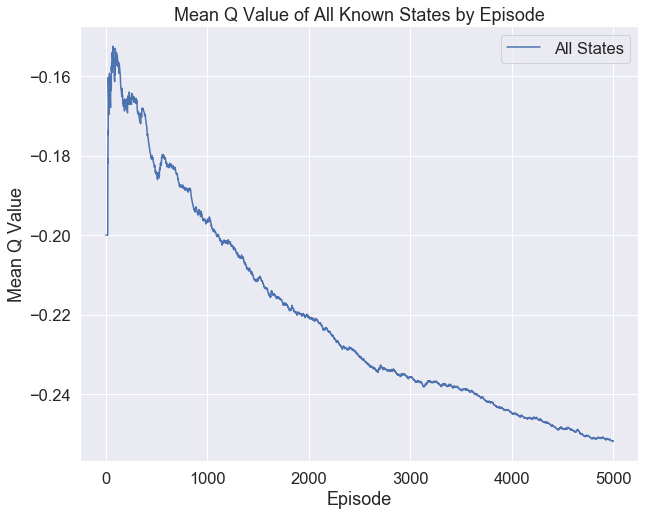

In [83]:
# Analyse mean Q value of all known states (ignoring 0's) to evaluate whether results have converged or not
sns.set(rc={'figure.figsize':(10,8)})
sns.set(font_scale=1.5)
plt.plot(Q_summary['episode'], Q_summary['mean_Q'],label='All States')
plt.legend()
plt.title("Mean Q Value of All Known States by Episode")
plt.xlabel("Episode")
plt.ylabel("Mean Q Value")

plt.show()

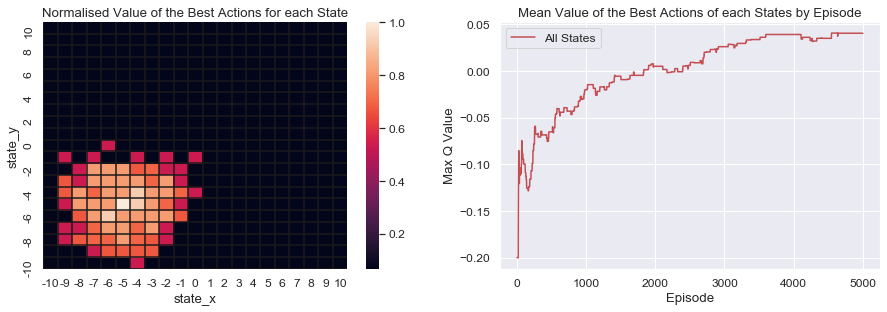

In [84]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.1)
pivot = state_action_values[["state_y", "state_x", "Q_norm"]].pivot("state_y", "state_x", "Q_norm")

ax = plt.subplot(221)
ax = sns.heatmap(pivot)
ax.hlines(range(-10,21), *ax.get_xlim())
ax.vlines(range(-10,21), *ax.get_ylim())
ax.set_title("Normalised Value of the Best Actions for each State")
ax.invert_yaxis()

ax2 = plt.subplot(222)
#ax2.plot(start_state_action_values['episode'], start_state_action_values['Q'], label = "Start State")
ax2.plot(best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['episode'],
         best_actions_table[best_actions_table['Q']!=0][['episode','Q']].groupby('episode').mean().reset_index()['Q'],label='All States',color='r')
ax2.legend()
ax2.set_title("Mean Value of the Best Actions of each States by Episode")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Max Q Value")

plt.show()


In [85]:
optimal_action_start_state = best_actions_table[(best_actions_table['state_x']==start_x)&(best_actions_table['state_y']==start_y)].sort_values('episode',ascending=False)
if (optimal_action_start_state['throw_dir'].iloc[0]=="none"):
    print("The optimal action from the start state is to MOVE in direction: ", optimal_action_start_state['move_dir'].iloc[0])
else:
    print("The optimal action from the start state is to THROW in direction: ", optimal_action_start_state['throw_dir'].iloc[0])

The optimal action from the start state is to THROW in direction:  46


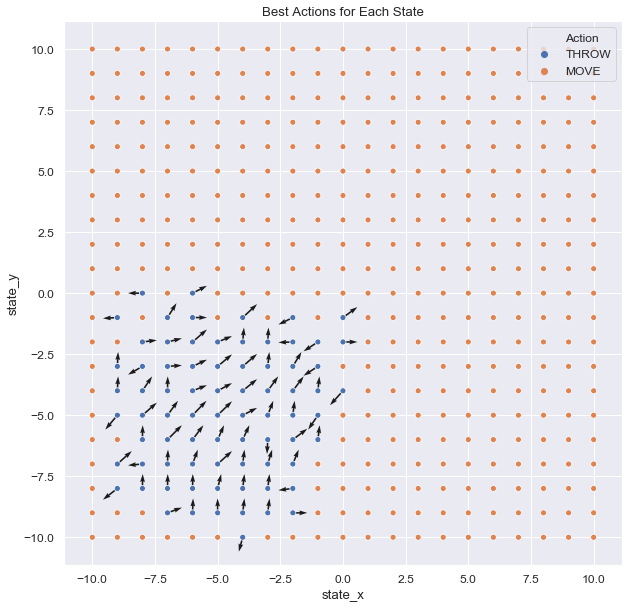

In [86]:
sns.set(font_scale=1.1)
# Create Quiver plot showing current optimal policy in one cell
arrow_scale = 0.1

optimal_action_list = state_action_values

optimal_action_list['Action'] = np.where( optimal_action_list['move_dir'] == 'none', 'THROW', 'MOVE'  )


optimal_action_list['move_x'] = np.where(optimal_action_list['move_dir'] == 0, int(0),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(1),
                                         np.where(optimal_action_list['move_dir'] == 3, int(1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(0),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 7, int(-1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['move_y'] = np.where(optimal_action_list['move_dir'] == 0, int(1),
                                         np.where(optimal_action_list['move_dir'] == 1, int(1),
                                         np.where(optimal_action_list['move_dir'] == 2, int(0),
                                         np.where(optimal_action_list['move_dir'] == 3, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 4, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 5, int(-1),
                                         np.where(optimal_action_list['move_dir'] == 6, int(0),
                                         np.where(optimal_action_list['move_dir'] == 7, int(1),
                                         int(-1000)
                                        ))))))))
optimal_action_list['throw_dir_2'] = np.where(optimal_action_list['throw_dir']=="none",int(-1000), optimal_action_list['throw_dir'])

# Define horizontal arrow component as 0.1*move direction or 0.1/-0.1 depending on throw direction
optimal_action_list['u'] = np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_x']*arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==0, 0,np.where(optimal_action_list['throw_dir_2']==180, 0,
                                    np.where(optimal_action_list['throw_dir_2']==90, arrow_scale ,np.where(optimal_action_list['throw_dir_2']==270, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']<180, arrow_scale,-arrow_scale))))))
                                             
# Define vertical arrow component based 0.1*move direciton or +/- u*tan(throw_dir) accordingly
# Make it show that unexplored states do not show an arrows
optimal_action_list['v'] = np.where(optimal_action_list['Q']==np.min(optimal_action_list['Q']), 0,
                                    np.where(optimal_action_list['Action']=="MOVE", optimal_action_list['move_y']*arrow_scale, 
                                    np.where(optimal_action_list['throw_dir_2']==0, arrow_scale,np.where(optimal_action_list['throw_dir_2']==180, -arrow_scale,
                                    np.where(optimal_action_list['throw_dir_2']==90, 0,np.where(optimal_action_list['throw_dir_2']==270, 0,
                                    np.where(optimal_action_list['throw_dir_2']<90,
                                        optimal_action_list['u']*np.tan(np.deg2rad(90-optimal_action_list['throw_dir_2'].astype(np.float64))),
                                    np.where(optimal_action_list['throw_dir_2']<180,
                                        optimal_action_list['u']*np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64)-90)),
                                    np.where(optimal_action_list['throw_dir_2']<270,
                                        optimal_action_list['u']*np.tan(np.deg2rad(270-optimal_action_list['throw_dir_2'].astype(np.float64))),
                                    np.where(optimal_action_list['throw_dir_2']<360,
                                        optimal_action_list['u']*np.tan(np.deg2rad(optimal_action_list['throw_dir_2'].astype(np.float64)-270)),-1000))))))))))
# Extreme values caused when angle close to 0 and 180. Manual fix to scale down arrows
optimal_action_list['u'] = np.where(optimal_action_list['v']>0.1, arrow_scale*(optimal_action_list['u']/optimal_action_list['v']),
                           np.where(optimal_action_list['v']<-0.1, -arrow_scale*(optimal_action_list['u']/optimal_action_list['v']), optimal_action_list['u']))
optimal_action_list['v'] = np.where(optimal_action_list['v']>0.1, arrow_scale*(optimal_action_list['v']/optimal_action_list['v']),
                           np.where(optimal_action_list['v']<-0.1, -arrow_scale*(optimal_action_list['v']/optimal_action_list['v']), optimal_action_list['v']))

x = optimal_action_list['state_x']
y = optimal_action_list['state_y']
u = optimal_action_list['u'].values
v = optimal_action_list['v'].values

plt.figure(figsize=(10, 10))
plt.quiver(x,y,u,v,scale=0.5,scale_units='inches')
sns.scatterplot( x="state_x", y="state_y", data=optimal_action_list,  hue='Action')
plt.title("Best Actions for Each State")
plt.show()

## Conclusion


So far we have replicated the typical process when following the standard approach to learning reinforcement learning. Specifically, using a pre-designed MDP provides all the information needed to let an agent begin learning, provided hyperparameters are given reasonable values.

However, this process falls short in two main regards:

- It does not explain the information required to model new problems.
- Simply running code may not fully demonstrate how updated values are calculated, relative to actually working through the update equations by hand.   

Therefore, we will now fully explain how the simulation for this problem was generated from real-world sensory type data. In the next chapter, we go through the agent's learning process step-by-step with mathematical calculations on The Classroom Environment.
